# Clean words MathLang

The aim of this notbeook is to clean all the words from the experiment mathlang in order to use embeddings on these words, to create the embeddings of the sentences and to compare these last embeddings with BOLD activation

In [1]:
import numpy as np
import pandas as pd
import os.path as op
import wave
import contextlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from french_lefff_lemmatizer.french_lefff_lemmatizer import FrenchLefffLemmatizer
import spacy
import string
from sklearn.decomposition import PCA, FastICA
import seaborn as sns

In [2]:
stims = pd.read_csv('matching_sentences_unique_number_and_number_cat_rev.csv', encoding='utf-8')
stims.head(140)

,unique_number,sentence,category,category_number,audio_file
0,1,Le résultat de vingt sept moins trois est le n...,arithfact,1,60_arithfact_01_true_vide_resultatvingtsept.wav
1,2,Le résultat de soixante dix neuf moins cinq es...,arithfact,2,8_arithfact_02_true_vide_soixantedixneuf.wav
2,3,La somme de cinquante cinq et deux donne cinqu...,arithfact,3,283_arithfact_03_true_vide_sommedecinquantecin...
3,4,Le produit de trois par sept a comme résultat ...,arithfact,4,108_arithfact_04_true_vide_produitdetrois.wav
4,5,Le nombre vingt sept divisé par trois donne co...,arithfact,5,119_arithfact_05_true_vide_nombrevingtsept.wav
...,...,...,...,...,...
135,136,Au Japon manger bruyamment est une forme de po...,context,16,317_context_16_true_faux_aujapon.wav
136,137,A Londres les voitures roulent à gauche de la ...,context,17,26_context_17_true_faux_londres.wav
137,138,Dans les contes pour enfants les animaux parle...,context,18,290_context_18_true_faux_contespourenfants.wav
138,139,En Irlande avoir les cheveux roux est assez co...,context,19,18_context_19_true_faux_irlande.wav


In [3]:
values_stim = pd.read_csv('Stimuli_exemple_Samuel.csv')
print(values_stim.head())
values_stim['Experiment']

   id                                           Stimulus  \
0   1  La série de Fourier d'une fonction f continue ...   
1   2  Toute fonction de R dans R localement polynomi...   
2   3  La fonction un sur gamma de z admet un prolong...   
3   4  Tout groupe topologique compact admet une mesu...   
4   5  Les fonctions test sont denses dans L p pour t...   

                                           AudioFile    Experiment  \
0  /neurospin/unicog/protocols/IRMf/mathematician...  MathsExperts   
1  /neurospin/unicog/protocols/IRMf/mathematician...  MathsExperts   
2  /neurospin/unicog/protocols/IRMf/mathematician...  MathsExperts   
3  /neurospin/unicog/protocols/IRMf/mathematician...  MathsExperts   
4  /neurospin/unicog/protocols/IRMf/mathematician...  MathsExperts   

  StimulusCategory  Mathematical TruthValue     Meaning  Length  
0         Analysis          True       True  Meaningful      20  
1         Analysis          True       True  Meaningful      11  
2         Analysis  

0       MathsExperts
1       MathsExperts
2       MathsExperts
3       MathsExperts
4       MathsExperts
           ...      
575    MathsLanguage
576    MathsLanguage
577    MathsLanguage
578    MathsLanguage
579    MathsLanguage
Name: Experiment, Length: 580, dtype: object

In [4]:
stims_value = np.empty((0,9))
values_matrix = np.array(values_stim)
for stimulus in range(0,values_matrix.shape[0]):
    if values_matrix[stimulus,3] == 'MathsLanguage':
        stims_value = np.vstack((stims_value,values_matrix[stimulus,:]))
print(stims_value[45,3:9])

['MathsLanguage' 'WordList' False 'False' 'Meaningless' 16]


In [5]:
ados_resp = pd.read_csv('stim_processing/all_15ado_resp_rt_for_each_sentence_ordered.csv', sep=';', names = ['Subject', 'block','modality_id','modality_cat','category','num_category', 'Truth_value','vide/T/F','modality','answer','reaction_time'])
adults_resp = pd.read_csv('stim_processing/all_resp_rt_for_each_sentence_v02_16subjects_ordered.csv', sep=';', names = ['Subject', 'block','modality_id','modality_cat','category','num_category', 'Truth_value','vide/T/F','modality','answer','reaction_time'])

In [6]:
ados_resp.head(5)

,Subject,block,modality_id,modality_cat,category,num_category,Truth_value,vide/T/F,modality,answer,reaction_time
0,subject101,block4,14,arithfact_video,arithfact,1,True,vide,video,1,5103
1,subject102,block1,13,arithfact_audio,arithfact,1,True,vide,audio,1,4797
2,subject103,block5,14,arithfact_video,arithfact,1,True,vide,video,1,9000
3,subject104,block4,13,arithfact_audio,arithfact,1,True,vide,audio,1,4648
4,subject105,block5,14,arithfact_video,arithfact,1,True,vide,video,0,4790


In [7]:
def modality_check(file_resp):
    file_array = np.array(file_resp)
    sentence_modality = np.zeros((320,1))
    for stimulus in range(0,file_array.shape[0]):
        if file_array[stimulus, 2] == 'arithfact':
            if file_array[stimulus,6] == 'audio':
                sentence_modality[file_array[stimulus,3]-1,0] = 1 #if stimulus is audio, value = 1
            else:
                sentence_modality[file_array[stimulus,3]-1,0] = -1 #if stimulus is video, value = 0
        if file_array[stimulus, 2] == 'arithprin':
            if file_array[stimulus,6] == 'audio':
                sentence_modality[file_array[stimulus,3]+39,0] = 1 #if stimulus is audio, value = 1
            else:
                sentence_modality[file_array[stimulus,3]+39,0] = -1 #if stimulus is video, value = 0
        if file_array[stimulus, 2] == 'control':
            if file_array[stimulus,6] == 'audio':
                sentence_modality[file_array[stimulus,3]+79,0] = 1 #if stimulus is audio, value = 1
            else:
                sentence_modality[file_array[stimulus,3]+79,0] = -1 #if stimulus is video, value = 0
        if file_array[stimulus, 2] == 'context':
            if file_array[stimulus,6] == 'audio':
                sentence_modality[file_array[stimulus,3]+119,0] = 1 #if stimulus is audio, value = 1
            else:
                sentence_modality[file_array[stimulus,3]+119,0] = -1 #if stimulus is video, value = 0
        if file_array[stimulus, 2] == 'colorlessg':
            if file_array[stimulus,6] == 'audio':
                sentence_modality[file_array[stimulus,3]+159,0] = 1 #if stimulus is audio, value = 1
            else:
                sentence_modality[file_array[stimulus,3]+159,0] = -1 #if stimulus is video, value = 0
        if file_array[stimulus, 2] == 'general':
            if file_array[stimulus,6] == 'audio':
                sentence_modality[file_array[stimulus,3]+199,0] = 1 #if stimulus is audio, value = 1
            else:
                sentence_modality[file_array[stimulus,3]+199,0] = -1 #if stimulus is video, value = 0
        if file_array[stimulus, 2] == 'geomfact':
            if file_array[stimulus,6] == 'audio':
                sentence_modality[file_array[stimulus,3]+239,0] = 1 #if stimulus is audio, value = 1
            else:
                sentence_modality[file_array[stimulus,3]+239,0] = -1 #if stimulus is video, value = 0
        if file_array[stimulus, 2] == 'tom':
            if file_array[stimulus,6] == 'audio':
                sentence_modality[file_array[stimulus,3]+279,0] = 1 #if stimulus is audio, value = 1
            else:
                sentence_modality[file_array[stimulus,3]+279,0] = -1 #if stimulus is video, value = 0
    return sentence_modality
    


In [53]:
SUBJECTS = list(range(1,17))+list(range(101,116))
all_modalities = np.zeros((320,1))
for i in range(all_modalities.shape[0]):
    all_modalities[i,0]=i+1
for subj in SUBJECTS:
    all_files = np.empty((0,9))
    for block in range(1,6):
        file = pd.read_csv(f'stim_processing/subject{subj:02d}_onsets_and_responses/responses_and_rt_each_sentence_subject{subj:02d}_block{block}.csv', sep = ';',
                           names = ['num_modality', 'cat_modality','category','num_category','truth_value', 'vide/T/F','modality','answer','reaction_time'])
        all_files = np.vstack((all_files,np.array(file)))
    modality_sentences = modality_check(all_files)
    print(subj,all_files.shape)
    all_modalities = np.hstack((all_modalities, modality_sentences))
all_modalities[104,2]=-1
all_modalities[296,3] = None
all_modalities[60,12] = 1
all_modalities[59,30] = -1
all_modalities[79,31] = -1
all_modalities[179,27] = 1
all_modalities[31,18] = 1
all_modalities[52,18] = -1
all_modalities[170,18] = 1
all_modalities[266,18] = -1
all_modalities[271,18] = 1
all_modalities[11,19] = 1
all_modalities[60,19] = -1
all_modalities[62,19] = -1
all_modalities[209,19] = 1
all_modalities[252,19] = -1

1 (320, 9)
2 (320, 9)
3 (320, 9)
4 (320, 9)
5 (320, 9)
6 (320, 9)
7 (320, 9)
8 (320, 9)
9 (320, 9)
10 (320, 9)
11 (320, 9)
12 (319, 9)
13 (320, 9)
14 (320, 9)
15 (320, 9)
16 (320, 9)
101 (320, 9)
102 (315, 9)
103 (315, 9)
104 (320, 9)
105 (320, 9)
106 (320, 9)
107 (320, 9)
108 (320, 9)
109 (320, 9)
110 (320, 9)
111 (319, 9)
112 (320, 9)
113 (320, 9)
114 (319, 9)
115 (319, 9)


In [57]:
for subj in SUBJECTS:
    if subj>=101:
        print(subj,np.where(all_modalities[:,subj-84] == 0)[0])
    else:
        print(subj,np.where(all_modalities[:,subj] == 0)[0])

1 []
2 []
3 []
4 []
5 []
6 []
7 []
8 []
9 []
10 []
11 []
12 []
13 []
14 []
15 []
16 []
101 []
102 []
103 []
104 []
105 []
106 []
107 []
108 []
109 []
110 []
111 []
112 []
113 []
114 []
115 []


In [79]:
list_sentence_sum_modality = []
for i in range(all_modalities.shape[0]):
    print(np.sum(all_modalities[i,1:])/31)
    list_sentence_sum_modality.append(np.sum(all_modalities[i,1:])/31)
array_modality = np.array(list_sentence_sum_modality).reshape(320,1)
print(array_modality.shape)

0.03225806451612903
0.0967741935483871
-0.2903225806451613
-0.22580645161290322
-0.22580645161290322
0.0967741935483871
-0.16129032258064516
0.2903225806451613
0.03225806451612903
-0.16129032258064516
-0.03225806451612903
0.03225806451612903
-0.16129032258064516
-0.0967741935483871
0.03225806451612903
0.0967741935483871
-0.2903225806451613
0.41935483870967744
0.2903225806451613
0.22580645161290322
0.2903225806451613
0.03225806451612903
-0.22580645161290322
0.03225806451612903
0.3548387096774194
0.22580645161290322
0.16129032258064516
-0.03225806451612903
0.03225806451612903
-0.0967741935483871
-0.22580645161290322
0.0967741935483871
0.0967741935483871
-0.03225806451612903
0.03225806451612903
-0.0967741935483871
-0.03225806451612903
-0.41935483870967744
0.03225806451612903
-0.22580645161290322
0.0967741935483871
-0.2903225806451613
-0.2903225806451613
0.22580645161290322
0.3548387096774194
-0.2903225806451613
-0.0967741935483871
-0.0967741935483871
0.03225806451612903
0.0322580645161290

In [68]:
def rate_answer_sentence(file_resp):
    resp = np.array(file_resp)
    total_answer = []
    reaction_time = []
    sentence_answer = []
    sentence_reaction_time = []
    for answer in range(0,resp.shape[0]):
        if len(total_answer)%40+1 == resp[answer,5]:
            sentence_answer.append(resp[answer,9])
            sentence_reaction_time.append(resp[answer,10])
        else:
            total_answer.append(np.sum(sentence_answer)/len(sentence_answer))
            reaction_time.append(np.sum(sentence_reaction_time)/len(sentence_reaction_time))
            sentence_answer = []
            sentence_reaction_time = []
            sentence_answer.append(resp[answer,9])
            sentence_reaction_time.append(resp[answer,10])
    reaction_time.append(np.sum(sentence_reaction_time)/len(sentence_reaction_time))
    total_answer.append(np.sum(sentence_answer)/len(sentence_answer))
    total_answer[73]=1-total_answer[73] #sentence True written as False
    print(np.min(total_answer),np.min(reaction_time))
    return total_answer, reaction_time

rate_answer_adults, reaction_time_adults = rate_answer_sentence(adults_resp)
rate_answer_ados, reaction_time_ados = rate_answer_sentence(ados_resp)
            

0.0625 3100.5
0.06666666666666667 3933.866666666667


In [69]:
total_answer_time = np.array([rate_answer_adults, rate_answer_ados, reaction_time_adults, reaction_time_ados]).T
print(total_answer_time.shape)

(320, 4)


### Create csv with indications on the sentences to test on the Norman-haignere analysis

In [70]:
stim_matrix = np.array(stims)
stim_matrix.shape

(320, 5)

In [71]:
audio_path = 'stim_processing/StimuliAudio'
TEXT_DURATION = 350
def get_duration(stimulus_audio, stimulus_video):
    fname = op.join(audio_path, stimulus_audio)
    with contextlib.closing(wave.open(fname,'r')) as f:
        frames = f.getnframes()
        rate = f.getframerate()
        audio_duration = int(1000*frames/float(rate))
    
    wlist = stimulus_video.split()
    video_duration = TEXT_DURATION * len(wlist)
    return audio_duration,video_duration

In [72]:
count=0
if 'est' in stim_matrix[1,1]:
    count+=1
print(count)
print(stim_matrix[1,1].split(),len(stim_matrix[1,1]))

1
['Le', 'résultat', 'de', 'soixante', 'dix', 'neuf', 'moins', 'cinq', 'est', 'soixante', 'quatorze.'] 66


In [ ]:
'''create sub-categories'''
## calculation & arithmetic principles: Fraction, addition, substraction, comparison, division, square root
fraction = [13,15,18,25,26,37,17,52,57,58,75,76,77]
addition = [3,14,29,43,49,50,55,67,70]
substraction = [1,2,11,19,32,45,61,64,68,71,74]
division = [5,16,21,24,30,38,48,43,54,69,79]
multiplication = [4,6,7,9,10,12,20,27,28,31,35,36,40,41,42,46,47,51,56,65,66,72,80]
comparison = [33,34,39,44]
square = [8,22,23,59,60,63,78]
even = [62,73]

## colorless green: condition or not
condition = list(range(84,95))
other = [81,82,83]+list(range(95,121))

## context geography or religion, person:
geography_country_town = [121,122,123,124,125,126,128,129,130,131,133,135,136,137,139,140,142,144,147,148,149,151,152,153,154,155,156,158,159,160]
geography_planet_size = [145,146,157]
religion = [127,132,134,141,143]
other = [138,150]

## list of words: grammar, nouns
grammar = list(range(161,181))
nouns = list(range(181,201))

## general : animal, botanic, chemistry, planets,
animal = [201,203,205,206,208,214,221,222,223,224,228,229,231]
botanic= [202,215,216,225]
chemistry_physics = [204,209,210,232]
planets_time = [207,217,218,226,227,233,234,235,236,238,239,240]
books = [212,213,230,237]
biology = [212,219,220]

## Geometry : geometrical_shapes (square, triangle, rectangle), lines
squares = [241,243,247,251,253,258,259,260,267,279]
triangle = [242,250,264,265,270,273,274,275,276]
other_shapes = [244,252,257,262,263,269,271,272,278]
lines_angles = [245,246,248,266,277,280]
circles = [249,254,255,256,261,268]

##Tom :
scientist = [281,282,284,286,287,288,316,320]
writer = [283,285,303,313,319]
historical_people = [289,298,301,309,312,315,317,318]
current_people = [290,294,295,302,304,305,307,310,311,314]
fiction_people = [297,300,308]
religious = [291,292,293,296,299,306]


In [73]:
'''add spatial notion of sentences'''
nothing_spatial = [39]+list(range(41,81))+[127,132,134,138,150,206,228,230,231,232,233,234,235,237,281,283,284,285,288,289,292,293,295,296,297,298,300,301,302,304,306,307,308,310,311,313]+list(range(201,205))+list(range(209,218))+list(range(219,226))+list(range(315,321))
very_spatial = list(range(121,127))+[128,129,130,131,133,135,136,137]+list(range(139,150))+list(range(151,161))+[205,207,208,218,226,227,229,236,238,239,240,282,286,287,290,291,294,299,303,305,309,312,314]
make_calculation = list(range(1,39))+[40]
geometry = list(range(241,265))+list(range(266,281))
list_words = list(range(81,121))+list(range(161,201))
    

In [74]:
'''add congruent notion or incongruent, True only in a certain context'''
incongruent = [122,124,125,126,281,286,288,312,313]+list(range(128,153))+list(range(154,161))+list(range(290,311))
congruent = list(range(1,41))+list(range(41,81))+[121,123,127,153]+list(range(201,281))+[282,283,284,285,287,289,311,314,315,316,317,318,319,320]
control_sentences = list(range(161,201))+list(range(81,121))
print(len(incongruent))
print(len(congruent))

62
178


In [80]:
sentences_details = np.empty((0,16))
for i in range(stim_matrix.shape[0]):
    for j in range(stims_value.shape[0]):
        one_sentence = []
        vb_etre = False
        feminine = False
        plural = False
        indefinite = False
        generality = True
        spatial_value = 'error'
        math_value = 'error'
        if stim_matrix[i,2] == 'arithfact' or stim_matrix[i,2] == 'arithprin' or stim_matrix[i,2] == 'geomfact' :
            math_value = 'math'
        if stim_matrix[i,2] == 'general' or stim_matrix[i,2] == 'context' or stim_matrix[i,2] == 'tom' :
            math_value = 'language'
        if stim_matrix[i,2] == 'colorlessg' or stim_matrix[i,2] == 'control':
            math_value = 'control'
        audio_duration , video_duration= get_duration(stim_matrix[i,4],stim_matrix[i,1])
        if 'est ' in stim_matrix[i,1] or 'sont ' in stim_matrix[i,1]:
            vb_etre = True
        if 'la ' in stim_matrix[i,1] or 'une ' in stim_matrix[i,1] or 'La ' in stim_matrix[i,1] or 'Une ' in stim_matrix[i,1]:
            feminine = True
        if 'les ' in stim_matrix[i,1] or 'des ' in stim_matrix[i,1] or 'Les ' in stim_matrix[i,1] or 'Des ' in stim_matrix[i,1]:
            plural = True
        if 'une ' in stim_matrix[i,1] or 'un ' in stim_matrix[i,1] or 'Une ' in stim_matrix[i,1] or 'Un ' in stim_matrix[i,1] or 'des ' in stim_matrix[i,1] or 'Des ' in stim_matrix[i,1] or 'Tout ' in stim_matrix[i,1]:
            indefinite = True
        if stim_matrix[i,0] in nothing_spatial:
            spatial_value = 'nothing_spatial'
        if stim_matrix[i,0] in very_spatial:
            spatial_value = 'very_spatial'
        if stim_matrix[i,0] in make_calculation:
            spatial_value = 'make_calculation'
        if stim_matrix[i,0] in geometry:
            spatial_value = 'geometry'
        if stim_matrix[i,0] in list_words:
            spatial_value = 'list_words' 
        if stim_matrix[i,0] in incongruent:
            generality = 'incongruent'
        if stim_matrix[i,0] in congruent:
            generality = 'congruent'   
        if stim_matrix[i,0] in control_sentences:
            generality = 'control'
        if stim_matrix[i,4] == stims_value[j,2].split('/',11)[-1]:
            count=0
            for letter in stim_matrix[i,1]:
                if letter != ' ' and letter!= '.' and letter!= '-' and letter!=',' and letter !="'":
                    count+=1
            one_sentence+=[stim_matrix[i,0],stim_matrix[i,1],stim_matrix[i,2],math_value,stims_value[j,6],stims_value[j,7],stims_value[j,8],count, vb_etre, feminine, plural, indefinite,spatial_value, audio_duration, video_duration, generality]
            sentences_details = np.vstack((sentences_details, one_sentence))
sentences_details = np.hstack((sentences_details, total_answer_time))
sentences_details = np.hstack((sentences_details, array_modality))
print(sentences_details, sentences_details.shape)


[['1' 'Le résultat de vingt sept moins trois est le nombre vingt quatre.'
  'arithfact' ... '5298.9375' '5614.266666666666' '0.03225806451612903']
 ['2'
  'Le résultat de soixante dix neuf moins cinq est soixante quatorze.'
  'arithfact' ... '5436.875' '6074.866666666667' '0.0967741935483871']
 ['3' 'La somme de cinquante cinq et deux donne cinquante sept.'
  'arithfact' ... '4482.0625' '5056.8' '-0.2903225806451613']
 ...
 ['318' "D'après Mère Teresa la haine est une émotion positive." 'tom'
  ... '4662.6875' '5493.266666666666' '0.03225806451612903']
 ['319' "D'après les humoristes rire est mauvais pour la santé." 'tom'
  ... '3938.125' '5022.933333333333' '-0.03225806451612903']
 ['320' 'Pour Einstein la bombe atomique est un objet sans danger.' 'tom'
  ... '4935.5' '5171.2' '0.2903225806451613']] (320, 21)


In [82]:
df = pd.DataFrame(data=sentences_details, columns=['unique_number','sentence','category','upper categories','Truth_value','Meaning','nb_words','nb_letters', 'vb_etre','feminine' ,'plural','indefinite','spatial_value','audio_duration','video_duration','generality_value', 'rate answer adults', 'rate answer ados' ,'reaction time adults', 'reaction time ados','modality'])
df.to_excel('sentence_information_details.xlsx',index=False)
df.to_csv('sentence_information_details.csv',index=False)

## Analysis GloVe on the sentences

In [199]:
words_lemmatized = pd.read_excel('Lemmatisation_test.xlsx')
words_lemmatized_array = np.array(words_lemmatized['Lemmes inclus dans le vocabulaire'])
print(words_lemmatized_array[0])

for i in range(0, words_lemmatized_array.shape[0]):
    words_lemmatized_array[i] = words_lemmatized_array[i].split(', ')
print(words_lemmatized_array[0])

word_MathLang=[]
for l in range(0, words_lemmatized_array.shape[0]):
    word_MathLang+=words_lemmatized_array[l]
print(word_MathLang)

le, résultat, d, vingt, sept, moins, trois, être, le, nombre, vingt, quatre
['le', 'résultat', 'd', 'vingt', 'sept', 'moins', 'trois', 'être', 'le', 'nombre', 'vingt', 'quatre']
['le', 'résultat', 'd', 'vingt', 'sept', 'moins', 'trois', 'être', 'le', 'nombre', 'vingt', 'quatre', 'le', 'résultat', 'd', 'soixante', 'dix', 'neuf', 'moins', 'cinq', 'être', 'soixer', 'quatorze', 'le', 'somme', 'd', 'cinquante', 'cinq', 'et', 'deux', 'donne', 'cinquante', 'sept.', 'le', 'produit', 'd', 'trois', 'par', 'sept', 'avoir', 'comme', 'résultat', 'vingt', 'et', 'un', 'le', 'nombre', 'vingt', 'sept', 'diviser', 'par', 'trois', 'donne', 'comme', 'résultat', 'neuf', 'le', 'nombre', 'trois', 'multiplier', 'par', 'douze', 'faire', 'trente', 'six', 'deux', 'fois', 'vingt', 'quatre', 'avoir', 'comme', 'résultat', 'quarante', 'huit', 'le', 'racine', 'carré', 'd', 'trente', 'six', 'être', 'plus', 'grand', 'que', 'cinq', 'quarante', 'cinq', 'être', 'le', 'résultat', 'd', 'quinze', 'fois', 'trois', 'le', 'résu

In [211]:
embeddings = pd.read_csv('wordEmbedding.csv')
#columns = ['word']+ list(range(1,51))

#embeddings = pd.read_csv("GloVe/vectors_all_50_dimensions.txt", delimiter=" ", encoding = 'utf8')
#embeddings.columns = columns

Let's check if we miss some embeddings for some words in Mathlang

In [212]:
print(list(embeddings.word))
print(len(list(embeddings.word)))

['de', 'le', 'et', 'un', 'à', 'être', 'en', 'il', 'dans', 'avoir', 'son', 'par', 'au', 'pour', 'ce', 'que', 'sur', 'se', 'qui', 'lui', 'avec', 'l', 'plus', 'd', 'ou', 'premier', 'faire', 'référence', 'comme', '||', 'deux', 'français', 'grand', 'pas', 'pouvoir', 'tout', 'saint', 'après', 'mais', 'note', 'leur', 'lien', 'entre', 'ne', 'aussi', 'autre', 'the', 'année', 'nouveau', 'france', 'sous', 'externe', 'n', 'commune', 'an', 'même', 'naissance', 'état', 'film', 'on', 'voir', 'celui', 'pari', 'ville', 'dont', 'nom', 'pourcent', 'où', 'y', 'ainsi', 'histoire', 'lors', 'alors', 'également', 'depuis', 'naître', 'groupe', 'jean', 'national', 'devenir', 'of', '2', 'américain', '1', 'partie', 's', 'joueur', 'jeu', 'puis', 'article', 'guerre', 'décès', 'nord', 'sud', 'trois', 'mettre', 'contre', 'situer', 'ancien', 'équipe', 'général', 'titre', 'saison', 'série', 'monde', 'plusieurs', 'site', 'avant', 'dernier', 'liste', 'pays', 'politique', 'devoir', 'uni', 'vers', 'permettre', 'famille', '

In [213]:
def missing_embeddings(data,embeddings):
    missing_words = []
    for word in data:
        if word not in list(embeddings.word):
            if word not in missing_words:
                missing_words.append(word)
    return missing_words

missing_words_mathlang = missing_embeddings(word_MathLang,embeddings)
print(missing_words_mathlang)
print(len(missing_words_mathlang))

['grimace', 'assoiffer', 'imperceptible', 'évent', 'titiller', 'biberon', 'centigrade', 'primevère', 'équilatéral', 'isocèle', 'équilatérau', 'climatologue', 'vulcanologue', 'elysée', 'créationniste']
15


In [185]:
embeddings_word = embeddings.loc[embeddings.word == 'Ronaldo'].to_numpy()[0,2:]
print(embeddings_word)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [216]:
def create_embeddings_sentences(words_lemmatized_array,embeddings):
    array_embeddings = np.empty([0,300])
    for sentence in range(words_lemmatized_array.shape[0]):
        embeddings_sentence = np.empty([0,300])
        for word in words_lemmatized_array[sentence]:
            if word not in missing_words_mathlang:
                embeddings_word = embeddings.loc[embeddings.word == word].to_numpy()[0,2:]
            embeddings_sentence= np.vstack((embeddings_sentence,embeddings_word))
        array_embeddings= np.vstack((array_embeddings, np.sum(embeddings_sentence, axis=0)/embeddings_sentence.shape[0]))  
    return array_embeddings

embeddings_array = create_embeddings_sentences(words_lemmatized_array, embeddings)
print(embeddings_array.shape)
embeddings_data = np.delete(embeddings_array, 264, 0)
print(embeddings_data.shape)

(320, 300)
(319, 300)


Export to csv embeddings array

In [217]:
df = pd.DataFrame(data=embeddings_data)
df.index = np.arange(1, len(df) + 1)
print(df)
df.to_csv('embeddings_sentences_MathLang.csv')

          0         1         2         3         4         5         6    \
1    0.222861  0.004907  0.288581 -0.102803 -0.084906 -0.071745  0.052694   
2    0.263569  0.050561  0.340026 -0.105933 -0.074198  -0.09237  0.136437   
3    0.136383  0.080568   0.22226  -0.05981 -0.191142  0.008407 -0.007922   
4    0.149256  0.059082  0.223521 -0.097808 -0.110529  0.026731  0.042051   
5    0.178723  0.069961  0.207232 -0.015816 -0.139561 -0.087658  0.014005   
..        ...       ...       ...       ...       ...       ...       ...   
315  0.172252 -0.072671  0.051608 -0.120721 -0.184698 -0.043215 -0.301581   
316  -0.08391 -0.115043  0.101303 -0.027247 -0.164011 -0.112734  0.132088   
317  0.068671  0.035817  0.130917 -0.007875 -0.167197  0.102161   0.10884   
318  0.148822  0.004745  0.063342 -0.189367  -0.05302  0.101221  0.005334   
319  0.189608 -0.177919  0.051795 -0.033859 -0.263009 -0.115634  0.074021   

          7         8         9    ...       290       291       292  \
1  

In [218]:
ncomponents= 9
pca = PCA(n_components= ncomponents)
data_pca = pca.fit_transform(embeddings_data)
print(data_pca.shape)

(319, 9)


In [45]:
K = 9 # number of components
X=np.float64(embeddings_data.T)
print(X.shape, type(X))
from npica import ICA
N_RANDOM_INITS = 1000
RAND_SEED = 0
ica = ICA(K=K,N_RANDOM_INITS=N_RANDOM_INITS,RAND_SEED=RAND_SEED)
ica.fit(X)
print(ica.sources)

(50, 319) <class 'numpy.ndarray'>
[[ 0.05518477  0.04679072  0.04877551 ... -0.01172144  0.03402137
   0.04397212]
 [ 0.03053268  0.02879117  0.0248577  ... -0.00384171  0.00213318
   0.01001217]
 [-0.12965269 -0.19780188 -0.13581777 ...  0.10215684  0.07473825
   0.07474384]
 ...
 [ 0.24385535  0.20020757  0.12097666 ...  0.17904777  0.17203556
   0.17362345]
 [ 0.04055843  0.02626555  0.04643017 ...  0.10146368  0.05191395
   0.11978715]
 [ 0.04525549  0.03975241  0.04318557 ...  0.02932807  0.08588572
  -0.09401665]]


In [189]:
data_pca = ica.sources.T

0.13405907926377655


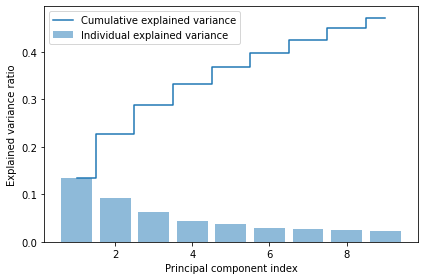

In [219]:
exp_var_pca = pca.explained_variance_ratio_
print(exp_var_pca[0])
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
#
plt.bar(range(1,len(exp_var_pca)+1), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1,len(cum_sum_eigenvalues)+1), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
#plt.vlines(6.0, 0, 0.8, linestyles ="dotted", colors ="k")
#plt.vlines(20, 0, 0.8, linestyles ="dotted", colors ="b")
t = np.arange(1.0, ncomponents, 1)
s = 0.015*t+0.50
#plt.plot(t, s)
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [220]:
def sort_values(data_pca):
    index_pca_sorted = np.argsort(data_pca)+1
    for i in range(index_pca_sorted.shape[0]):
        if index_pca_sorted[i]>=265:
            index_pca_sorted[i]=index_pca_sorted[i]+1
    value_pca_sorted = np.sort(data_pca)
    pca_sorted_dict = dict(zip(index_pca_sorted,value_pca_sorted))
    pca_sorted_dict = {str(k):v for k,v in pca_sorted_dict.items()}
    return pca_sorted_dict, index_pca_sorted

In [221]:
pca_sorted_dict_0, index_pca_sorted_0 = sort_values(data_pca[:,0])
pca_sorted_dict_1, index_pca_sorted_1 = sort_values(data_pca[:,1])
pca_sorted_dict_2, index_pca_sorted_2 = sort_values(data_pca[:,2])
pca_sorted_dict_3, index_pca_sorted_3 = sort_values(data_pca[:,3])
pca_sorted_dict_4, index_pca_sorted_4 = sort_values(data_pca[:,4])
pca_sorted_dict_5, index_pca_sorted_5 = sort_values(data_pca[:,5])
pca_sorted_dict_6, index_pca_sorted_6 = sort_values(data_pca[:,6])
pca_sorted_dict_7, index_pca_sorted_7 = sort_values(data_pca[:,7])
pca_sorted_dict_8, index_pca_sorted_8 = sort_values(data_pca[:,8])

In [222]:
def compute_barplot_parameters_category(pca_sorted_dict, index_pca_sorted):
    names = pca_sorted_dict.keys()
    values = pca_sorted_dict.values()

    bar_colors =[]
    for i in index_pca_sorted:
        if i> 0 and i < 41 and len(bar_colors)<320:
            bar_colors.append('gold')
        if i> 40 and i < 81:
            bar_colors.append('chocolate')
        if i> 80 and i < 121:
            bar_colors.append('grey')
        if i> 120 and i < 161:
            bar_colors.append('cornflowerblue')
        if i> 160 and i < 201:
            bar_colors.append('lightgrey')
        if i> 200 and i < 241:
            bar_colors.append('darkturquoise')
        if i> 240 and i < 281:
            bar_colors.append('red')
        if i> 280 and i < 321:
            bar_colors.append('mediumblue')
    return names, values, bar_colors

In [223]:
names_0, values_0, bar_colors_0 = compute_barplot_parameters_category(pca_sorted_dict_0,index_pca_sorted_0)
names_1, values_1, bar_colors_1 = compute_barplot_parameters_category(pca_sorted_dict_1,index_pca_sorted_1)
names_2, values_2, bar_colors_2 = compute_barplot_parameters_category(pca_sorted_dict_2,index_pca_sorted_2)
names_3, values_3, bar_colors_3 = compute_barplot_parameters_category(pca_sorted_dict_3,index_pca_sorted_3)
names_4, values_4, bar_colors_4 = compute_barplot_parameters_category(pca_sorted_dict_4,index_pca_sorted_4)
names_5, values_5, bar_colors_5 = compute_barplot_parameters_category(pca_sorted_dict_5,index_pca_sorted_5)
names_6, values_6, bar_colors_6 = compute_barplot_parameters_category(pca_sorted_dict_6,index_pca_sorted_6)
names_7, values_7, bar_colors_7 = compute_barplot_parameters_category(pca_sorted_dict_7,index_pca_sorted_7)
names_8, values_8, bar_colors_8 = compute_barplot_parameters_category(pca_sorted_dict_8,index_pca_sorted_8)

In [224]:
custom_lines = [Line2D([0], [0], color='lightgrey', lw=4),
                Line2D([0], [0], color='grey', lw=4),
                Line2D([0], [0], color='darkturquoise', lw=4),
                Line2D([0], [0], color='cornflowerblue', lw=4),
                Line2D([0], [0], color='mediumblue', lw=4),
                Line2D([0], [0], color='gold', lw=4),
                Line2D([0], [0], color='chocolate', lw=4),
                Line2D([0], [0], color='red', lw=4),
                ]
bar_labels = ['List of words', 'Meaningless sentences','Factual knowledge','Contextual knowledge','Social knowledge', 'Calculation', 'Arithmetic principles',  'Geometry']

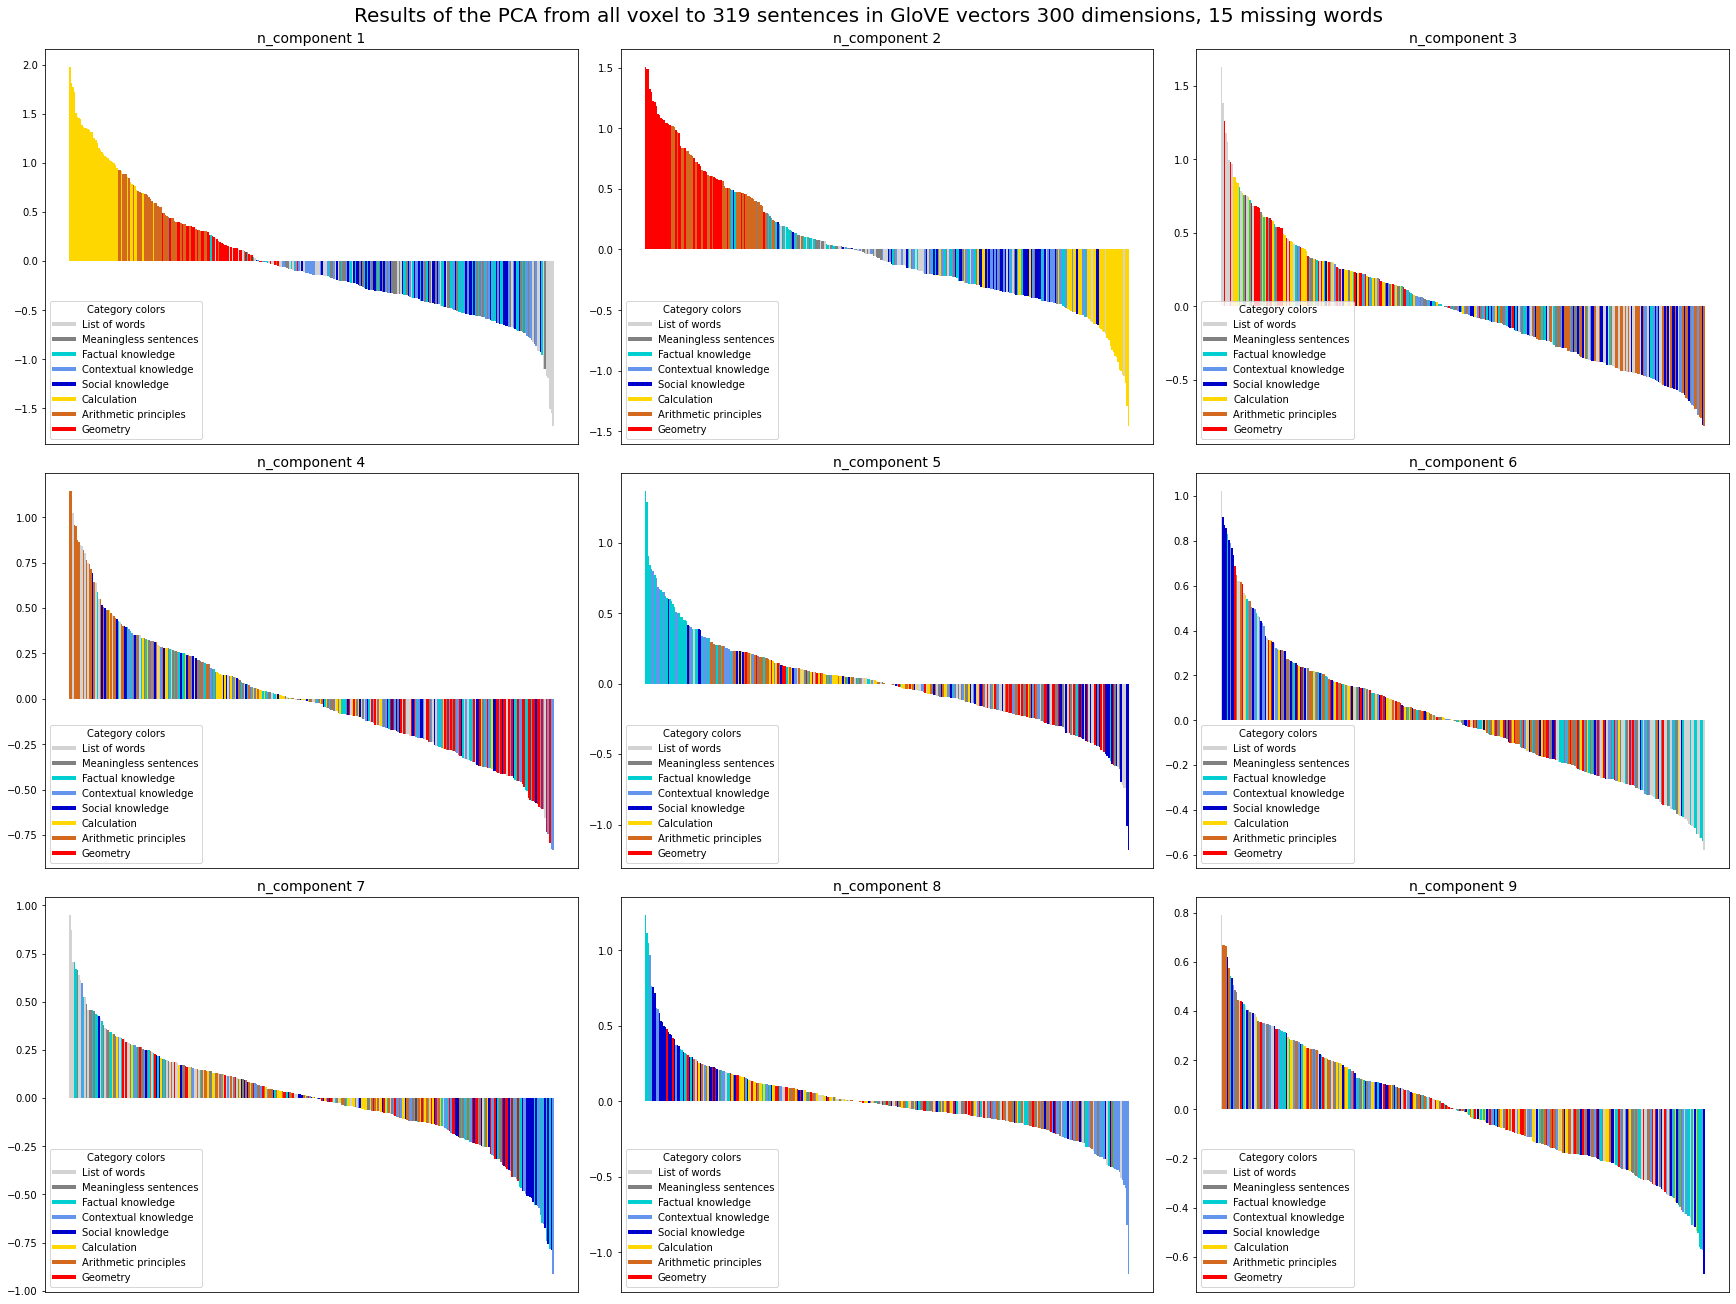

In [226]:
fig, axs = plt.subplots(3, 3, layout='constrained', figsize = (24,18))

axs[0,0].bar(names_0, values_0, color=bar_colors_0, label=bar_labels, width=1)
axs[0,0].set_title('n_component 1', size = 14)
axs[0,0].legend(custom_lines, bar_labels, title='Category colors', loc = 3, prop = { "size": 10})
axs[0,0].invert_xaxis()
axs[0,0].xaxis.set_visible(False)
axs[0,1].bar(names_1, values_1, color=bar_colors_1, label=bar_labels, width=1)
axs[0,1].set_title('n_component 2', size = 14)
axs[0,1].legend(custom_lines, bar_labels, title='Category colors', loc = 3, prop = { "size": 10})
axs[0,1].invert_xaxis()
axs[0,1].xaxis.set_visible(False)
axs[0,2].bar(names_2, values_2, color=bar_colors_2, label=bar_labels, width=1)
axs[0,2].set_title('n_component 3', size = 14)
axs[0,2].legend(custom_lines, bar_labels, title='Category colors', loc = 3, prop = { "size": 10})
axs[0,2].invert_xaxis()
axs[0,2].xaxis.set_visible(False)
axs[1,0].bar(names_3, values_3, color=bar_colors_3, label=bar_labels, width=1)
axs[1,0].set_title('n_component 4', size = 14)
axs[1,0].legend(custom_lines, bar_labels, title='Category colors', loc = 3, prop = { "size": 10})
axs[1,0].invert_xaxis()
axs[1,0].xaxis.set_visible(False)
axs[1,1].bar(names_4, values_4, color=bar_colors_4, label=bar_labels, width=1)
axs[1,1].set_title('n_component 5', size = 14)
axs[1,1].legend(custom_lines, bar_labels, title='Category colors', loc = 3, prop = { "size": 10})
axs[1,1].invert_xaxis()
axs[1,1].xaxis.set_visible(False)
axs[1,2].bar(names_5, values_5, color=bar_colors_5, label=bar_labels, width=1)
axs[1,2].set_title('n_component 6', size = 14)
axs[1,2].legend(custom_lines, bar_labels, title='Category colors', loc = 3, prop = { "size": 10})
axs[1,2].invert_xaxis()
axs[1,2].xaxis.set_visible(False)
axs[2,0].bar(names_6, values_6, color=bar_colors_6, label=bar_labels, width=1)
axs[2,0].set_title('n_component 7', size = 14)
axs[2,0].legend(custom_lines, bar_labels, title='Category colors', loc = 3, prop = { "size": 10})
axs[2,0].invert_xaxis()
axs[2,0].xaxis.set_visible(False)
axs[2,1].bar(names_7, values_7, color=bar_colors_7, label=bar_labels, width=1)
axs[2,1].set_title('n_component 8', size = 14)
axs[2,1].legend(custom_lines, bar_labels, title='Category colors', loc = 3, prop = { "size": 10})
axs[2,1].invert_xaxis()
axs[2,1].xaxis.set_visible(False)
axs[2,2].bar(names_8, values_8, color=bar_colors_8, label=bar_labels, width=1)
axs[2,2].set_title('n_component 9', size = 14)
axs[2,2].legend(custom_lines, bar_labels, title='Category colors', loc = 3, prop = { "size": 10})
axs[2,2].invert_xaxis()
axs[2,2].xaxis.set_visible(False)

fig.suptitle(f'Results of the PCA from all voxel to 319 sentences in GloVE vectors 300 dimensions, 15 missing words', size =20)
plt.show()

In [41]:
ados_matrix_pca = pd.read_csv('ados_matrix_sentencesXpca_components.csv')
adults_matrix_pca = pd.read_csv('adults_matrix_sentencesXpca_components.csv')

In [49]:
matrix_data_pca_gloVE = pd.concat([adults_matrix_pca, pd.DataFrame(data_pca)], axis = 1)
matrix_data_pca_gloVE.head()

,0,1,2,3,4,5,6,7,8,0,1,2,3,4,5,6,7,8
0,-596.715003,78.904740,139.331230,32.519981,17.892111,-36.850636,39.045625,197.526358,41.623518,1.366192,-0.669696,0.246544,-0.067803,0.233753,-0.049668,-0.041012,-0.014910,-0.095405
1,-388.671859,-174.417737,-11.525557,-100.278376,-55.609440,4.189498,183.743601,52.087794,-8.604315,1.458437,-1.094288,0.577477,0.116258,0.164575,0.225261,-0.132127,-0.027365,-0.243061
2,-440.100501,-77.636377,122.862750,-90.115455,-58.020677,71.832704,-81.212938,6.690703,53.008617,1.024790,-0.685431,0.495500,0.118435,-0.051326,0.320089,-0.060153,0.028393,0.254390
3,-406.253856,-50.586100,266.728007,-62.872773,35.396509,38.310471,-20.749896,3.336256,53.020350,0.599293,-0.385192,-0.103139,-0.109446,0.097262,-0.081785,-0.083430,0.003025,-0.125154
4,-519.812060,84.390977,137.471113,-16.562997,91.716674,-19.013619,87.001849,105.329645,135.139105,1.229213,-0.431897,0.167236,0.015446,0.070265,0.060367,-0.093768,0.147492,-0.019907


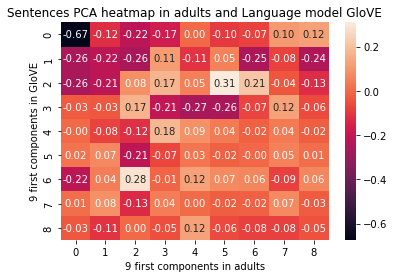

In [50]:
corr_npica = matrix_data_pca_gloVE.corr()
corr_matrix_sub_npica=corr_npica.values
df_matrix_npica=pd.DataFrame(corr_matrix_sub_npica[9:,:9])
ax = plt.axes()
sns.heatmap(df_matrix_npica, annot=True, ax=ax, fmt=".2f")
ax.set_title(f'Sentences PCA heatmap in adults and Language model GloVE')
plt.xlabel('9 first components in adults')
plt.ylabel('9 first components in GloVE')
plt.show()